In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from itertools import combinations
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import importlib.util

In [2]:
#print(sys.path)

In [2]:
sys.path.insert(1, "C:/Users/Mi/Documents/Diploma/GMDH/build/Release")
sys.path.insert(1, "/home/mikhail-xnor/Projects/GMDH/build")

In [3]:
import gmdhpy as gm

In [4]:
dir(gm)

['COMBI',
 'Criterion',
 'CriterionType',
 'GmdhModel',
 'MIA',
 'MULTI',
 'ParallelCriterion',
 'PolynomialType',
 'RIA',
 'SequentialCriterion',
 'Solver',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'splitData',
 'splitted_data',
 'timeSeriesTransformation']

In [6]:
def data_preparation(x, lags, validate_size, test_size=0):
    #print("x: ", x)
    x_data = list()
    y_data = list()
    for i in range(len(x) - lags):
        x_data.append(list(x.values[i:i+lags]))
        y_data.append(x.values[i+lags])
    x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=validate_size, shuffle=False)
    x_train = np.array(x_train)
    x_val = np.array(x_val)
    #print("x_train:\n", x_train)
    #print("y_train:\n", y_train)
    #print("x_val:\n", x_val)
    #print("y_val:\n", y_val)
    if test_size > 0:
        x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=test_size, shuffle=False)
        x_train = np.array(x_train)
        x_test = np.array(x_test)
        return x_train, y_train, x_test, y_test, x_val, y_val
    else:
        return x_train, y_train, x_val, y_val

def print_polynom(polynom, coeffs):
    best_polynom_str = "y ="
    for i in range(len(polynom)):
        if coeffs[i] > 0:
            if i > 0:
                best_polynom_str += " + "
            else:
                best_polynom_str += " "
        else:
            best_polynom_str += " - "
        best_polynom_str += str(abs(coeffs[i]))
        if i != len(coeffs) - 1:
            best_polynom_str += "*x" + str(polynom[i] + 1)
    print(best_polynom_str)

In [7]:
def regression(x, lags, validate_size):
    x_train, y_train, x_val, y_val = data_preparation(x, lags, validate_size)
    lr = LinearRegression(n_jobs=-1)
    lr.fit(x_train, y_train)
    coeffs = list(lr.coef_)
    coeffs.append(lr.intercept_)
    coeffs = [round(coeff, 6) for coeff in coeffs]
    y_pred = lr.predict(x_val)
    error = round(mean_squared_error(y_pred, y_val), 6)
    print_polynom(range(lags + 1), coeffs)
    return y_pred

In [8]:
def regression_combi(x, lags, validate_size, test_size):
    x_train, y_train, x_test, y_test, x_val, y_val = data_preparation(x, lags, validate_size, test_size)
    lr = LinearRegression(n_jobs=-1)
    last_error = 100000000000000
    best_coeffs = []
    best_polynom = []
    for level in range(1, x_train.shape[1] + 1):
        errors = []
        for comb in combinations(range(x_train.shape[1]), level):
            lr.fit(x_train[:, comb], y_train)
            coeffs = list(lr.coef_)
            coeffs.append(lr.intercept_)
            coeffs = [round(coeff, 6) for coeff in coeffs]
            y_pred = lr.predict(x_test[:, comb])
            error = round(mean_squared_error(y_pred, y_test), 6)
            comb = list(comb)
            comb.append(lags)
            errors.append((error, coeffs, comb))
        errors.sort()
        #print(errors[0])
        if last_error > errors[0][0]:
            last_error = errors[0][0]
            best_coeffs = errors[0][1]
            best_polynom = errors[0][2]
        else:
            break
    best_polynom_str = "y ="
    print_polynom(best_polynom, best_coeffs)
    y_pred = lr.fit(x_train[:, best_polynom[:-1]], y_train).predict(x_val[:, best_polynom[:-1]])
    return y_pred

In [5]:
%%time
data = pd.read_csv("Sberbank.csv")['close'][:-50000]
lags = 10
test_size = 0.33
validate_size = 0.2

CPU times: total: 609 ms
Wall time: 596 ms


In [6]:
%%time
mat, vec = gm.timeSeriesTransformation(data, lags)
splited_data = gm.splitData(mat, vec, validate_size, False, 0)

CPU times: total: 46.9 ms
Wall time: 47.1 ms


In [9]:
%%time
combi = gm.COMBI()
combi.fit(splited_data.x_train, splited_data.y_train, gm.Criterion(gm.CriterionType.regularity, gm.Solver.accurate), test_size, 0, 0, 1, 1, 1)
print(combi.getBestPolynomial())
y_pred_combi = combi.predict(splited_data.x_test)

LEVEL 1  [==============================] 100% :00s] (10 combinations)                                              
LEVEL 2  [==============================] 100% :00s] (45 combinations)                                              
LEVEL 3  [==============================] 100% :01s] (120 combinations)                                             
LEVEL 4  [==============================] 100% :03s] (210 combinations)                                             
LEVEL 5  [==============================] 100% :05s] (252 combinations)                                             
LEVEL 6  [==============================] 100% :05s] (210 combinations)                                             
y = 0.0075*x1 - 0.0056*x2 - 0.0085*x4 + 0.014*x9 + 0.9925*x10 + 0.013
CPU times: total: 22.9 s
Wall time: 17.6 s


In [10]:
%%time
multi = gm.MULTI()
multi.fit(splited_data.x_train, splited_data.y_train, gm.Criterion(gm.CriterionType.regularity, gm.Solver.accurate), 0, 0, 0, 0, 0, -10, 1);
print(multi.getBestPolynomial())
y_pred_multi = multi.predict(splited_data.x_test)

<timed exec>:2: Warning: 
Warning! The input value of testSize is incorrect!
The default value is used (testSize = 0.5)!

<timed exec>:2: Warning: 
Warning! The input number of threads is incorrect!
The default value is used (threads = 1)!

<timed exec>:2: Warning: 
Warning! The input number of pAverage is incorrect!
The default value is used (pAverage = 1)!

<timed exec>:2: Warning: 
Warning! The input number of kBest is incorrect!
The default value is used (kBest = 1)!




LEVEL 2  [==============================] 100% :00s] (9 combinations)                                               
LEVEL 3  [==============================] 100% :00s] (8 combinations)                                               
LEVEL 4  [==============================] 100% :00s] (7 combinations)                                               
LEVEL 5  [==============================] 100% :00s] (6 combinations)                                               
LEVEL 6  [==============================] 100% :00s] (5 combinations)                                               
LEVEL 7  [==============================] 100% :00s] (4 combinations)                                               
y = 0.0081*x1 - 0.006*x2 + 0.0027*x3 - 0.0117*x4 + 0.0139*x9 + 0.9929*x10 + 0.0071
CPU times: total: 1.2 s
Wall time: 1.12 s


In [15]:
try:
    y_pred_multi = multi.predict(np.delete(splited_data.x_test, -1, 1))
except Exception as err:
    print(err)

Input data number of cols is not match number of cols of fitted data!


In [12]:
%%time
mia = gm.MIA()
mia.fit(splited_data.x_train, splited_data.y_train, gm.Criterion(gm.CriterionType.regularity, gm.Solver.accurate), 5, gm.PolynomialType.quadratic, test_size, 0, 0, 0, -2, 1);
print(mia.getBestPolynomial())
y_pred_mia = mia.predict(splited_data.x_test)

<timed exec>:2: Warning: 
Warning! The input number of threads is incorrect!
The default value is used (threads = 1)!

<timed exec>:2: Warning: 
Warning! The input number of pAverage is incorrect!
The default value is used (pAverage = 1)!



LEVEL 1  [==============================] 100% :01s] (45 combinations)                                              
LEVEL 2  [==============================] 100% :00s] (10 combinations)                                              
y = - 0.0101*x4 + 1.0099*x10 - 0.0039*x4*x10 + 0.002*x4^2 + 0.0019*x10^2 + 0.0172
CPU times: total: 2.16 s
Wall time: 1.66 s


In [13]:
%%time
ria = gm.RIA()
ria.fit(splited_data.x_train, splited_data.y_train, gm.Criterion(gm.CriterionType.regularity, gm.Solver.accurate), 5, gm.PolynomialType.quadratic, test_size, 0, 0, 0, -2, 1);
print(ria.getBestPolynomial())
y_pred_ria = ria.predict(splited_data.x_test)

<timed exec>:2: Warning: 
Warning! The input number of threads is incorrect!
The default value is used (threads = 1)!

<timed exec>:2: Warning: 
Warning! The input number of pAverage is incorrect!
The default value is used (pAverage = 1)!



LEVEL 1  [==============================] 100% :01s] (45 combinations)                                              
LEVEL 2  [==============================] 100% :01s] (50 combinations)                                              
LEVEL 3  [==============================] 100% :01s] (50 combinations)                                              
LEVEL 4  [==============================] 100% :01s] (50 combinations)                                              
f1 = - 0.0335*x7 + 1.0327*x10 + 0.0085*x7*x10 - 0.0041*x7^2 - 0.0044*x10^2 + 0.038
f2 = 0.0065*x4 + 0.9939*f1 - 0.0067*x4*f1 + 0.0033*x4^2 + 0.0034*f1^2 - 0.0186
y = 7.59589e-05*x4 + 0.9999*f2 + 0.0003*x4*f2 - 0.0001*x4^2 - 0.0001*f2^2 + 0.0007
CPU times: total: 7.08 s
Wall time: 5.78 s


In [16]:
%%time
y_pred_lr_combi = regression_combi(data, lags, validate_size, test_size)

y = 0.007414*x1 - 0.005515*x2 - 0.008639*x4 + 0.014119*x9 + 0.992471*x10 + 0.013064
CPU times: total: 29.1 s
Wall time: 29.3 s


In [17]:
%time
y_pred_lr = regression(data, lags, validate_size)

CPU times: total: 0 ns
Wall time: 0 ns
y = 0.009259*x1 - 0.007186*x2 + 0.002076*x3 - 0.009886*x4 + 0.008726*x5 - 0.016363*x6 + 0.002292*x7 + 0.00249*x8 + 0.018962*x9 + 0.989674*x10 - 0.003019


In [18]:
#np.savetxt("Sber.csv", np.asarray(data.values), delimiter=",")

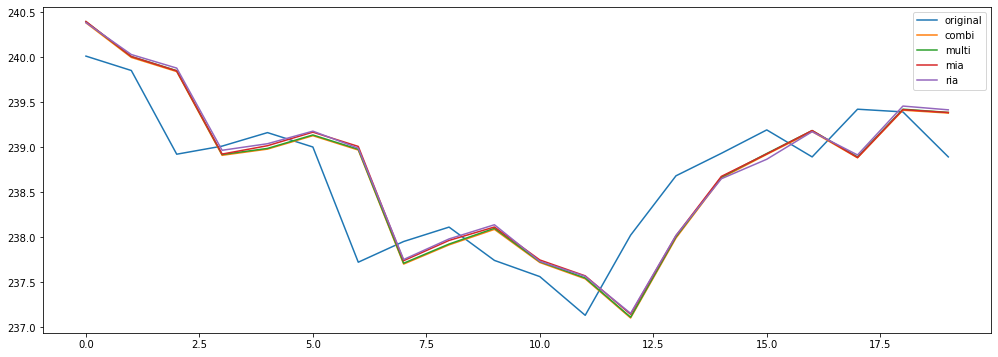

In [17]:
n = 20
plt.figure(figsize=(17, 6))
sns.lineplot(x=np.arange(n), y=splited_data.y_test[:n], label='original');
sns.lineplot(x=np.arange(n), y=y_pred_combi[:n], label='combi');
sns.lineplot(x=np.arange(n), y=y_pred_multi[:n], label='multi');
sns.lineplot(x=np.arange(n), y=y_pred_mia[:n], label='mia');
sns.lineplot(x=np.arange(n), y=y_pred_ria[:n], label='ria');
#sns.lineplot(x=np.arange(n), y=y_pred_lr_combi[:n], label='regr_combi');
#sns.lineplot(x=np.arange(n), y=y_pred_lr[:n], label='regr');

In [13]:
def stat(y_real, y_pred):
    y_real_diff = np.diff(y_real)
    y_pred_diff = np.diff(y_pred)
    print("right:", ((y_real_diff * y_pred_diff > 0)).sum())
    print("wrong:", ((y_real_diff * y_pred_diff < 0)).sum())
    print("zero:", ((y_real_diff * y_pred_diff == 0)).sum())

In [14]:
print("COMBI")
stat(splited_data.y_test, y_pred_combi)
print("\nMULTI")
stat(splited_data.y_test, y_pred_multi)
print("\nMIA")
stat(splited_data.y_test, y_pred_mia)
print("\nRIA")
stat(splited_data.y_test, y_pred_ria)

COMBI
right: 9414
wrong: 10602
zero: 304

MULTI
right: 9414
wrong: 10602
zero: 304

MIA
right: 9424
wrong: 10589
zero: 307

RIA
right: 9419
wrong: 10597
zero: 304
